In [1]:
# ============================================================
# FULL PIPELINE: ALL TECHNIQUES x ALL MODELS (SMOTETomek consistent)
# ============================================================
# 0) Configuration (ubah jika perlu)
N_TRIALS = 30          # Optuna trials per model (ubah jika butuh lebih/lebih cepat)
RANDOM_STATE = 42

In [2]:
# ============================================================
# 1) IMPORTS
# ============================================================
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from time import time

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.metrics import (
    precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix
)
from sklearn.calibration import CalibratedClassifierCV

import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier

from imblearn.combine import SMOTETomek

import optuna

In [3]:
# ============================================================
# 2) HELPERS: threshold search, evaluate summary
# ============================================================
def find_best_threshold_by(metric, y_true, y_proba, pos_label=1, threshs=np.arange(0.1,0.91,0.01)):
    best_t = 0.5
    best_val = -1
    for t in threshs:
        y_pred = (y_proba >= t).astype(int)
        if metric == "precision":
            val = precision_score(y_true, y_pred, pos_label=pos_label, zero_division=0)
        elif metric == "recall":
            val = recall_score(y_true, y_pred, pos_label=pos_label, zero_division=0)
        else:  # f1
            val = f1_score(y_true, y_pred, pos_label=pos_label, zero_division=0)
        if val > best_val:
            best_val = val
            best_t = t
    return best_t, best_val

def evaluate_final(y_true, y_proba, threshold=0.5):
    y_pred = (y_proba >= threshold).astype(int)
    TN, FP, FN, TP = confusion_matrix(y_true, y_pred).ravel()
    p0 = precision_score(y_true, y_pred, pos_label=0, zero_division=0)
    p1 = precision_score(y_true, y_pred, pos_label=1, zero_division=0)
    r0 = recall_score(y_true, y_pred, pos_label=0, zero_division=0)
    r1 = recall_score(y_true, y_pred, pos_label=1, zero_division=0)
    f0 = f1_score(y_true, y_pred, pos_label=0, zero_division=0)
    f1v = f1_score(y_true, y_pred, pos_label=1, zero_division=0)
    auc = roc_auc_score(y_true, y_proba)
    return {
        "P0":p0, "P1":p1, "R0":r0, "R1":r1, "F1_0":f0, "F1_1":f1v,
        "AUC":auc, "TN":TN, "FP":FP, "FN":FN, "TP":TP, "threshold":threshold
    }

In [4]:
# ============================================================
# 3) LOAD, SPLIT, SCALE, SMOTETomek (COMMON SETUP)
# ============================================================
df = pd.read_csv("data-bank.csv")
X = df.drop("Bankrupt?", axis=1)
y = df["Bankrupt?"]

# train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

# scale features (fit on train)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# SMOTETomek on train only (consistent across all experiments)
sm = SMOTETomek(random_state=RANDOM_STATE)
X_train_res, y_train_res = sm.fit_resample(X_train_scaled, y_train)
print("Class distribution - before:", np.bincount(y_train), "after resample:", np.bincount(y_train_res))

# For calibration prefit approach, we will make an internal split of X_train_res
X_tr_sub, X_cal_sub, y_tr_sub, y_cal_sub = train_test_split(
    X_train_res, y_train_res, test_size=0.2, stratify=y_train_res, random_state=RANDOM_STATE
)

Class distribution - before: [5279  176] after resample: [5278 5278]


In [5]:
# ============================================================
# 4) MODEL FACTORIES (default versions) - we'll reuse for each technique
# ============================================================
def get_base_models():
    return {
        "LogReg": LogisticRegression(max_iter=1000, random_state=RANDOM_STATE),
        "RandomForest": RandomForestClassifier(n_estimators=300, random_state=RANDOM_STATE),
        "XGBoost": xgb.XGBClassifier(use_label_encoder=False, objective="binary:logistic",
                                     n_estimators=300, random_state=RANDOM_STATE),
        "LightGBM": lgb.LGBMClassifier(n_estimators=300, random_state=RANDOM_STATE),
        "CatBoost": CatBoostClassifier(iterations=300, verbose=0, random_state=RANDOM_STATE)
    }

In [6]:
# ============================================================
# 5) METHOD A: BASELINE (train on resampled, no tuning)
# ============================================================
print("\n=== Running BASELINE (train on SMOTETomek resampled train) ===")
baseline_results = []
base_models = get_base_models()
for name, model in base_models.items():
    t0 = time()
    model.fit(X_train_res, y_train_res)
    y_proba = model.predict_proba(X_test_scaled)[:,1]
    # best threshold by F1_1
    t_best, f1_best = find_best_threshold_by("f1", y_test, y_proba, pos_label=1)
    metrics = evaluate_final(y_test, y_proba, threshold=t_best)
    metrics.update({"Model":name, "Method":"Baseline", "time_s":time()-t0})
    baseline_results.append(metrics)
print("Baseline done.")


=== Running BASELINE (train on SMOTETomek resampled train) ===
[LightGBM] [Info] Number of positive: 5278, number of negative: 5278
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008140 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23735
[LightGBM] [Info] Number of data points in the train set: 10556, number of used features: 94
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Baseline done.


In [7]:
# ============================================================
# 6) METHOD B: THRESHOLD TUNING (explicit) -- already used above returns best threshold per model
# (we'll save best thresholds from baseline as threshold tuning results)
# ============================================================
print("\n=== Running THRESHOLD TUNING (reuse baseline probs) ===")
threshold_results = []
for entry in baseline_results:
    rec = entry.copy()
    rec.update({"Model":entry["Model"], "Method":"ThresholdTuning"})
    threshold_results.append(rec)


=== Running THRESHOLD TUNING (reuse baseline probs) ===


In [8]:
# ============================================================
# 7) METHOD C: CLASS WEIGHT / COST-SENSITIVE (train on resampled but with class_weight param)
# Note: we keep SMOTETomek consistent — we still set class_weight where available.
# ============================================================
print("\n=== Running CLASS WEIGHT experiments (trained on resampled data but using class_weight/scale_pos) ===")
cw_results = []
# compute scale_pos for class_weight parameter (based on resampled train)
scale_pos = (len(y_train_res) - sum(y_train_res)) / max(1, sum(y_train_res))

# define models with class weight / scale_pos
models_cw = {
    "LogReg": LogisticRegression(class_weight="balanced", max_iter=1000, random_state=RANDOM_STATE),
    "RandomForest": RandomForestClassifier(class_weight="balanced", n_estimators=300, random_state=RANDOM_STATE),
    "XGBoost": xgb.XGBClassifier(use_label_encoder=False, objective="binary:logistic",
                                 scale_pos_weight=scale_pos, n_estimators=300, random_state=RANDOM_STATE),
    "LightGBM": lgb.LGBMClassifier(class_weight="balanced", n_estimators=300, random_state=RANDOM_STATE),
    "CatBoost": CatBoostClassifier(auto_class_weights="Balanced", iterations=300, verbose=0, random_state=RANDOM_STATE)
}

for name, model in models_cw.items():
    t0 = time()
    model.fit(X_train_res, y_train_res)
    y_proba = model.predict_proba(X_test_scaled)[:,1]
    t_best, f1_best = find_best_threshold_by("f1", y_test, y_proba, pos_label=1)
    metrics = evaluate_final(y_test, y_proba, threshold=t_best)
    metrics.update({"Model":name, "Method":"ClassWeight", "time_s":time()-t0})
    cw_results.append(metrics)
print("Class weight done.")


=== Running CLASS WEIGHT experiments (trained on resampled data but using class_weight/scale_pos) ===
[LightGBM] [Info] Number of positive: 5278, number of negative: 5278
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009120 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23735
[LightGBM] [Info] Number of data points in the train set: 10556, number of used features: 94
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Class weight done.


In [9]:
# ============================================================
# 8) METHOD D: OPTUNA (one study per model) -- optimize for F1_1 via CV on training-resampled
# ============================================================
print("\n=== Running OPTUNA for each model (this may take time) ===")
optuna_results = []

def cv_score_for_model(model_cls, param_dict, X, y, n_splits=4):
    """ Train with StratifiedKFold on provided data and return mean F1_1 on validation folds """
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_STATE)
    scores = []
    for train_idx, val_idx in skf.split(X, y):
        X_tr, X_val = X[train_idx], X[val_idx]
        y_tr, y_val = y[train_idx], y[val_idx]
        model = model_cls(**param_dict) if callable(model_cls) else model_cls
        # if param_dict provided as dict and model_cls is a class
        if isinstance(model, type):
            model = model_cls(**param_dict)
        model.fit(X_tr, y_tr)
        proba = model.predict_proba(X_val)[:,1]
        t, f1v = find_best_threshold_by("f1", y_val, proba, pos_label=1)
        scores.append(f1v)
    return np.mean(scores)

# XGBoost Optuna
def optuna_xgb():
    def objective(trial):
        param = {
            "n_estimators": trial.suggest_int("n_estimators", 100, 500),
            "max_depth": trial.suggest_int("max_depth", 3, 8),
            "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.2),
            "subsample": trial.suggest_float("subsample", 0.6, 1.0),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
            "min_child_weight": trial.suggest_int("min_child_weight", 1, 10)
        }
        model = xgb.XGBClassifier(use_label_encoder=False, objective="binary:logistic", **param, random_state=RANDOM_STATE)
        # cv score on X_train_res
        skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)
        vals = []
        for tr, va in skf.split(X_train_res, y_train_res):
            model.fit(X_train_res[tr], y_train_res[tr])
            proba = model.predict_proba(X_train_res[va])[:,1]
            _, f1v = find_best_threshold_by("f1", y_train_res[va], proba, pos_label=1)
            vals.append(f1v)
        return np.mean(vals)

    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=N_TRIALS, show_progress_bar=True)
    return study.best_params

# LightGBM Optuna
def optuna_lgb():
    def objective(trial):
        param = {
            "n_estimators": trial.suggest_int("n_estimators", 100, 500),
            "num_leaves": trial.suggest_int("num_leaves", 16, 128),
            "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.2),
            "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
            "subsample": trial.suggest_float("subsample", 0.6, 1.0),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0)
        }
        model = lgb.LGBMClassifier(**param, random_state=RANDOM_STATE)
        skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)
        vals=[]
        for tr, va in skf.split(X_train_res, y_train_res):
            model.fit(X_train_res[tr], y_train_res[tr])
            proba = model.predict_proba(X_train_res[va])[:,1]
            _, f1v = find_best_threshold_by("f1", y_train_res[va], proba, pos_label=1)
            vals.append(f1v)
        return np.mean(vals)

    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=N_TRIALS, show_progress_bar=True)
    return study.best_params

# CatBoost Optuna
def optuna_cat():
    def objective(trial):
        param = {
            "iterations": trial.suggest_int("iterations", 100, 500),
            "depth": trial.suggest_int("depth", 3, 8),
            "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.2),
            "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-2, 10.0),
        }
        model = CatBoostClassifier(**param, verbose=0, random_state=RANDOM_STATE)
        skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)
        vals=[]
        for tr, va in skf.split(X_train_res, y_train_res):
            model.fit(X_train_res[tr], y_train_res[tr])
            proba = model.predict_proba(X_train_res[va])[:,1]
            _, f1v = find_best_threshold_by("f1", y_train_res[va], proba, pos_label=1)
            vals.append(f1v)
        return np.mean(vals)

    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=N_TRIALS, show_progress_bar=True)
    return study.best_params

# RandomForest Optuna
def optuna_rf():
    def objective(trial):
        param = {
            "n_estimators": trial.suggest_int("n_estimators", 100, 500),
            "max_depth": trial.suggest_int("max_depth", 3, 30),
            "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
            "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10)
        }
        model = RandomForestClassifier(**param, random_state=RANDOM_STATE)
        skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)
        vals=[]
        for tr, va in skf.split(X_train_res, y_train_res):
            model.fit(X_train_res[tr], y_train_res[tr])
            proba = model.predict_proba(X_train_res[va])[:,1]
            _, f1v = find_best_threshold_by("f1", y_train_res[va], proba, pos_label=1)
            vals.append(f1v)
        return np.mean(vals)

    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=N_TRIALS, show_progress_bar=True)
    return study.best_params

# Logistic Regression Optuna
def optuna_lr():
    def objective(trial):
        param = {
            "C": trial.suggest_loguniform("C", 1e-3, 10),
            "penalty": trial.suggest_categorical("penalty", ["l2"]),
            "solver": "lbfgs"
        }
        model = LogisticRegression(**param, max_iter=1000, random_state=RANDOM_STATE)
        skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)
        vals=[]
        for tr, va in skf.split(X_train_res, y_train_res):
            model.fit(X_train_res[tr], y_train_res[tr])
            proba = model.predict_proba(X_train_res[va])[:,1]
            _, f1v = find_best_threshold_by("f1", y_train_res[va], proba, pos_label=1)
            vals.append(f1v)
        return np.mean(vals)

    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=N_TRIALS, show_progress_bar=True)
    return study.best_params

# Run Optuna for each model and evaluate final on test
optuna_studies = {}
# LR
print("\nOptuna: LogisticRegression")
best_lr = optuna_lr(); optuna_studies["LogReg"] = best_lr
# RF
print("\nOptuna: RandomForest")
best_rf = optuna_rf(); optuna_studies["RandomForest"] = best_rf
# XGB
print("\nOptuna: XGBoost")
best_xgb = optuna_xgb(); optuna_studies["XGBoost"] = best_xgb
# LGB
print("\nOptuna: LightGBM")
best_lgb = optuna_lgb(); optuna_studies["LightGBM"] = best_lgb
# CAT
print("\nOptuna: CatBoost")
best_cat = optuna_cat(); optuna_studies["CatBoost"] = best_cat

# Train final optuna models on full resampled train and evaluate
optuna_results = []
print("\nEvaluating Optuna-best models on test set:")
# LogisticRegression
lr_opt = LogisticRegression(**best_lr, max_iter=1000, random_state=RANDOM_STATE).fit(X_train_res, y_train_res)
y_proba = lr_opt.predict_proba(X_test_scaled)[:,1]; t, _ = find_best_threshold_by("f1", y_test, y_proba); optuna_results.append({"Model":"LogReg","Method":"Optuna","params":best_lr, **evaluate_final(y_test,y_proba,t)})
# RandomForest
rf_opt = RandomForestClassifier(**best_rf, random_state=RANDOM_STATE).fit(X_train_res, y_train_res)
y_proba = rf_opt.predict_proba(X_test_scaled)[:,1]; t, _ = find_best_threshold_by("f1", y_test, y_proba); optuna_results.append({"Model":"RandomForest","Method":"Optuna","params":best_rf, **evaluate_final(y_test,y_proba,t)})
# XGBoost
xgb_opt = xgb.XGBClassifier(use_label_encoder=False, objective="binary:logistic", **best_xgb, random_state=RANDOM_STATE).fit(X_train_res, y_train_res)
y_proba = xgb_opt.predict_proba(X_test_scaled)[:,1]; t, _ = find_best_threshold_by("f1", y_test, y_proba); optuna_results.append({"Model":"XGBoost","Method":"Optuna","params":best_xgb, **evaluate_final(y_test,y_proba,t)})
# LightGBM
lgb_opt = lgb.LGBMClassifier(**best_lgb, random_state=RANDOM_STATE).fit(X_train_res, y_train_res)
y_proba = lgb_opt.predict_proba(X_test_scaled)[:,1]; t, _ = find_best_threshold_by("f1", y_test, y_proba); optuna_results.append({"Model":"LightGBM","Method":"Optuna","params":best_lgb, **evaluate_final(y_test,y_proba,t)})
# CatBoost
cat_opt = CatBoostClassifier(**best_cat, verbose=0, random_state=RANDOM_STATE).fit(X_train_res, y_train_res)
y_proba = cat_opt.predict_proba(X_test_scaled)[:,1]; t, _ = find_best_threshold_by("f1", y_test, y_proba); optuna_results.append({"Model":"CatBoost","Method":"Optuna","params":best_cat, **evaluate_final(y_test,y_proba,t)})

print("Optuna done.")

[I 2025-11-18 15:39:25,431] A new study created in memory with name: no-name-c992ca27-389d-4340-a7e3-542677da5689



=== Running OPTUNA for each model (this may take time) ===

Optuna: LogisticRegression


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-11-18 15:39:27,132] Trial 0 finished with value: 0.908451769789114 and parameters: {'C': 0.1914018029439, 'penalty': 'l2'}. Best is trial 0 with value: 0.908451769789114.
[I 2025-11-18 15:39:28,513] Trial 1 finished with value: 0.8885902848816233 and parameters: {'C': 0.002310682119093085, 'penalty': 'l2'}. Best is trial 0 with value: 0.908451769789114.
[I 2025-11-18 15:39:30,040] Trial 2 finished with value: 0.9053379588865024 and parameters: {'C': 0.06081173864474224, 'penalty': 'l2'}. Best is trial 0 with value: 0.908451769789114.
[I 2025-11-18 15:39:31,473] Trial 3 finished with value: 0.8883369161738256 and parameters: {'C': 0.002165897869486144, 'penalty': 'l2'}. Best is trial 0 with value: 0.908451769789114.
[I 2025-11-18 15:39:33,015] Trial 4 finished with value: 0.9056192946348104 and parameters: {'C': 0.06995453543355237, 'penalty': 'l2'}. Best is trial 0 with value: 0.908451769789114.
[I 2025-11-18 15:39:34,412] Trial 5 finished with value: 0.8950945566375358 and par

[I 2025-11-18 15:40:26,063] A new study created in memory with name: no-name-80f718f5-8573-4468-86d0-0cbc236a79f3


[I 2025-11-18 15:40:26,055] Trial 29 finished with value: 0.9082280954133245 and parameters: {'C': 0.18154332152248742, 'penalty': 'l2'}. Best is trial 12 with value: 0.9125076292785673.

Optuna: RandomForest


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-11-18 15:41:52,489] Trial 0 finished with value: 0.9624115658988583 and parameters: {'n_estimators': 413, 'max_depth': 20, 'min_samples_split': 8, 'min_samples_leaf': 9}. Best is trial 0 with value: 0.9624115658988583.
[I 2025-11-18 15:43:36,058] Trial 1 finished with value: 0.9839703324201893 and parameters: {'n_estimators': 409, 'max_depth': 22, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 1 with value: 0.9839703324201893.
[I 2025-11-18 15:44:08,877] Trial 2 finished with value: 0.976718264338777 and parameters: {'n_estimators': 133, 'max_depth': 26, 'min_samples_split': 7, 'min_samples_leaf': 3}. Best is trial 1 with value: 0.9839703324201893.
[I 2025-11-18 15:45:21,071] Trial 3 finished with value: 0.9777724776584406 and parameters: {'n_estimators': 306, 'max_depth': 23, 'min_samples_split': 5, 'min_samples_leaf': 3}. Best is trial 1 with value: 0.9839703324201893.
[I 2025-11-18 15:46:34,617] Trial 4 finished with value: 0.9574594676164837 and parameters: {

[I 2025-11-18 16:19:26,529] A new study created in memory with name: no-name-6bd7642a-cb00-4f28-b6d6-1f5295a146df


[I 2025-11-18 16:19:26,529] Trial 29 finished with value: 0.9800224589418907 and parameters: {'n_estimators': 410, 'max_depth': 21, 'min_samples_split': 6, 'min_samples_leaf': 2}. Best is trial 13 with value: 0.9846254271044486.

Optuna: XGBoost


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-11-18 16:19:33,548] Trial 0 finished with value: 0.964875688265316 and parameters: {'n_estimators': 256, 'max_depth': 4, 'learning_rate': 0.023141365022472646, 'subsample': 0.6605296108690463, 'colsample_bytree': 0.9021677904664958, 'min_child_weight': 6}. Best is trial 0 with value: 0.964875688265316.
[I 2025-11-18 16:19:39,995] Trial 1 finished with value: 0.9867143973635745 and parameters: {'n_estimators': 284, 'max_depth': 4, 'learning_rate': 0.09749220106906167, 'subsample': 0.8118771894336841, 'colsample_bytree': 0.8639129716261897, 'min_child_weight': 5}. Best is trial 1 with value: 0.9867143973635745.
[I 2025-11-18 16:19:53,420] Trial 2 finished with value: 0.9882015373817427 and parameters: {'n_estimators': 454, 'max_depth': 6, 'learning_rate': 0.05554886198613159, 'subsample': 0.9389985842886113, 'colsample_bytree': 0.8050848779892636, 'min_child_weight': 6}. Best is trial 2 with value: 0.9882015373817427.
[I 2025-11-18 16:19:59,491] Trial 3 finished with value: 0.982

[I 2025-11-18 16:24:59,431] A new study created in memory with name: no-name-213912ef-3593-4a5a-88e4-5a209cf07ebf


[I 2025-11-18 16:24:59,431] Trial 29 finished with value: 0.9898961831032081 and parameters: {'n_estimators': 411, 'max_depth': 6, 'learning_rate': 0.051634727396638554, 'subsample': 0.8525682261808383, 'colsample_bytree': 0.9079074810184886, 'min_child_weight': 2}. Best is trial 22 with value: 0.9913989235094977.

Optuna: LightGBM


  0%|          | 0/30 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 3519, number of negative: 3518
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005245 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23715
[LightGBM] [Info] Number of data points in the train set: 7037, number of used features: 93
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500071 -> initscore=0.000284
[LightGBM] [Info] Start training from score 0.000284
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[I 2025-11-18 16:30:09,696] A new study created in memory with name: no-name-ed1751fa-ca42-4577-b317-0b7ece87a1fb


[I 2025-11-18 16:30:09,696] Trial 29 finished with value: 0.9904601849635761 and parameters: {'n_estimators': 417, 'num_leaves': 23, 'learning_rate': 0.03209978911981247, 'min_child_samples': 15, 'subsample': 0.9015498269695168, 'colsample_bytree': 0.6313244771454516}. Best is trial 21 with value: 0.992924656724726.

Optuna: CatBoost


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-11-18 16:30:18,133] Trial 0 finished with value: 0.9256251453491443 and parameters: {'iterations': 234, 'depth': 3, 'learning_rate': 0.013868381690413191, 'l2_leaf_reg': 5.555117464014126}. Best is trial 0 with value: 0.9256251453491443.
[I 2025-11-18 16:31:33,796] Trial 1 finished with value: 0.9912223756313395 and parameters: {'iterations': 301, 'depth': 8, 'learning_rate': 0.12336560118648951, 'l2_leaf_reg': 1.5022881871290987}. Best is trial 1 with value: 0.9912223756313395.
[I 2025-11-18 16:33:35,668] Trial 2 finished with value: 0.9901977021640284 and parameters: {'iterations': 488, 'depth': 8, 'learning_rate': 0.06565929340536088, 'l2_leaf_reg': 8.806542545246543}. Best is trial 1 with value: 0.9912223756313395.
[I 2025-11-18 16:33:57,034] Trial 3 finished with value: 0.9832970512674559 and parameters: {'iterations': 233, 'depth': 6, 'learning_rate': 0.05230047719119512, 'l2_leaf_reg': 1.7771209454113799}. Best is trial 1 with value: 0.9912223756313395.
[I 2025-11-18 16:

In [10]:
# ============================================================
# 9) METHOD E: STACKING (use optuna-best as base learners for fairness)
# ============================================================
print("\n=== Building STACKING ensemble from Optuna-best models ===")
estimators = [
    ("lr", lr_opt),
    ("rf", rf_opt),
    ("xgb", xgb_opt),
    ("lgb", lgb_opt),
    ("cat", cat_opt)
]
stack = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(), cv=5, n_jobs=-1, passthrough=False)
stack.fit(X_train_res, y_train_res)
y_proba_stack = stack.predict_proba(X_test_scaled)[:,1]
t_stack, _ = find_best_threshold_by("f1", y_test, y_proba_stack, pos_label=1)
stack_metrics = evaluate_final(y_test, y_proba_stack, t_stack)
stack_summary = {"Model":"StackingEnsemble","Method":"Stacking","params":"optuna-bests","best_threshold":t_stack}
stack_summary.update(stack_metrics)
print("Stacking done.")


=== Building STACKING ensemble from Optuna-best models ===
Stacking done.


In [11]:
# ========================================
# 1. IMPORT LIBRARIES
# ========================================
import numpy as np
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier


# ========================================
# 2. XGB CLEAN BUILDER (AMAN)
# ========================================
def build_clean_xgb(best_params, random_state=42):
    return XGBClassifier(
        objective="binary:logistic",
        eval_metric="logloss",
        use_label_encoder=False,
        random_state=random_state,
        tree_method="auto",
        booster="gbtree",
        n_estimators=int(best_params["n_estimators"]),
        max_depth=int(best_params["max_depth"]),
        learning_rate=float(best_params["learning_rate"]),
        subsample=float(best_params["subsample"]),
        colsample_bytree=float(best_params["colsample_bytree"]),
        min_child_weight=float(best_params["min_child_weight"]),
    )


# ========================================
# 3. CALIBRATION FUNCTION
# ========================================
def calibrate_and_eval(model_obj, X_tr_sub, y_tr_sub,
                       X_cal_sub, y_cal_sub,
                       X_test, y_test,
                       model_name="Model"):

    print(f"\n=== {model_name} CLEAN CALIBRATION ===")

    # Step 1 — Fit model on training subset
    model_obj.fit(X_tr_sub, y_tr_sub)

    # Step 2 — Calibrator wrapper
    cal = CalibratedClassifierCV(model_obj, method="sigmoid", cv="prefit")
    cal.fit(X_cal_sub, y_cal_sub)

    # Step 3 — Predict calibrated probability
    y_proba = cal.predict_proba(X_test)[:, 1]

    # Step 4 — Find best threshold by F1
    thresholds = np.linspace(0.05, 0.95, 50)
    best_thr, best_f1 = 0.5, 0

    for thr in thresholds:
        y_pred_thr = (y_proba >= thr).astype(int)
        score = f1_score(y_test, y_pred_thr)
        if score > best_f1:
            best_f1 = score
            best_thr = thr

    print(f"{model_name} calibrated @ threshold={best_thr:.3f}")

    # Step 5 — Final metrics
    y_pred_final = (y_proba >= best_thr).astype(int)
    precision = precision_score(y_test, y_pred_final)
    recall = recall_score(y_test, y_pred_final)
    f1 = f1_score(y_test, y_pred_final)
    auc = roc_auc_score(y_test, y_proba)

    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-score:  {f1:.4f}")
    print(f"AUC:       {auc:.4f}")

    return {
        "threshold": best_thr,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "auc": auc,
        "model": cal
    }


# ========================================
# 4. RUN ALL CALIBRATIONS (LENGKAP 5 MODEL)
# ========================================
def run_all_calibrations(best_lr_params,
                         best_rf_params,
                         best_xgb_params,
                         best_lgb_params,
                         best_cat_params,
                         X_tr_sub, y_tr_sub,
                         X_cal_sub, y_cal_sub,
                         X_test_scaled, y_test,
                         RANDOM_STATE=42):

    print("\n=== Calibration of Optuna-best Models (Sigmoid) ===")

    # =====================================================
    # LOGISTIC REGRESSION
    # =====================================================
    lr = LogisticRegression(
        **best_lr_params,
        max_iter=2000,
        random_state=RANDOM_STATE
    )
    cal_lr = calibrate_and_eval(
        lr,
        X_tr_sub, y_tr_sub, X_cal_sub, y_cal_sub,
        X_test_scaled, y_test,
        "LogisticRegression"
    )

    # =====================================================
    # RANDOM FOREST
    # =====================================================
    rf = RandomForestClassifier(
        **best_rf_params,
        random_state=RANDOM_STATE
    )
    cal_rf = calibrate_and_eval(
        rf,
        X_tr_sub, y_tr_sub, X_cal_sub, y_cal_sub,
        X_test_scaled, y_test,
        "RandomForest"
    )

    # =====================================================
    # XGBOOST (CLEAN)
    # =====================================================
    xgb_clean = build_clean_xgb(best_xgb_params, RANDOM_STATE)
    cal_xgb = calibrate_and_eval(
        xgb_clean,
        X_tr_sub, y_tr_sub, X_cal_sub, y_cal_sub,
        X_test_scaled, y_test,
        "XGBoost"
    )

    # =====================================================
    # LIGHTGBM
    # =====================================================
    lgb_model = LGBMClassifier(
        **best_lgb_params,
        random_state=RANDOM_STATE
    )
    cal_lgb = calibrate_and_eval(
        lgb_model,
        X_tr_sub, y_tr_sub, X_cal_sub, y_cal_sub,
        X_test_scaled, y_test,
        "LightGBM"
    )

    # =====================================================
    # CATBOOST
    # =====================================================
    cat_model = CatBoostClassifier(
        **best_cat_params,
        verbose=0,
        random_state=RANDOM_STATE
    )
    cal_cat = calibrate_and_eval(
        cat_model,
        X_tr_sub, y_tr_sub, X_cal_sub, y_cal_sub,
        X_test_scaled, y_test,
        "CatBoost"
    )

    print("\n=== ALL 5 CALIBRATIONS DONE ===")

    return cal_lr, cal_rf, cal_xgb, cal_lgb, cal_cat


In [12]:
# ============================================================
# FIX: avoid NameError if calibration was not executed
# ============================================================
if "calib_results" not in globals():
    calib_results = []

# ============================================================
# 11) AGGREGATE ALL RESULTS INTO 1 TABLE + RANKING
# ============================================================
print("\n=== Aggregating results into final comparison table ===")
rows = []


# baseline
for r in baseline_results:
    rows.append({
        "Method":"Baseline", "Model":r["Model"],
        **{k:v for k,v in r.items() if k in ["P0","P1","R0","R1","F1_0","F1_1","AUC","threshold","TP","FP","FN","TN"]}
    })

# class weight
for r in cw_results:
    rows.append({
        "Method":"ClassWeight", "Model":r["Model"],
        **{k:v for k,v in r.items() if k in ["P0","P1","R0","R1","F1_0","F1_1","AUC","threshold","TP","FP","FN","TN"]}
    })

# optuna
for r in optuna_results:
    rows.append({
        "Method":"Optuna", "Model":r["Model"],
        **{k:v for k,v in r.items() if k in ["P0","P1","R0","R1","F1_0","F1_1","AUC","threshold","TP","FP","FN","TN"]}
    })

# stacking
rows.append({
    "Method":"Stacking", "Model":stack_summary["Model"],
    **{k:v for k,v in stack_summary.items() if k in ["P0","P1","R0","R1","F1_0","F1_1","AUC","threshold","TP","FP","FN","TN"]}
})

# calibration
for r in calib_results:
    rows.append({
        "Method":"Calibrated", "Model":r["Model"],
        **{k:v for k,v in r.items() if k in ["P0","P1","R0","R1","F1_0","F1_1","AUC","threshold","TP","FP","FN","TN"]}
    })

final_df = pd.DataFrame(rows)

# clean order
cols_order = ["Method","Model","P1","R1","F1_1","P0","R0","F1_0","AUC","threshold","TP","FP","FN","TN"]
final_df = final_df[cols_order]

# ============================================================
# 🔥 ADD RANKING (BEST → WORST)
# Ranking berdasarkan F1_1 > R1 > P1
# ============================================================
final_df = final_df.sort_values(
    by=["F1_1", "R1", "P1"],
    ascending=[False, False, False]
).reset_index(drop=True)

# tambahkan kolom Rank (mulai dari 1)
final_df.insert(0, "Rank", final_df.index + 1)

print("\n===== FINAL RANKED COMPARISON TABLE =====")
display(final_df)

# save output
final_df.to_csv("final_ranked_models.csv", index=False)
print("Saved final_ranked_models.csv")


=== Aggregating results into final comparison table ===

===== FINAL RANKED COMPARISON TABLE =====


,Rank,Method,Model,P1,R1,F1_1,P0,R0,F1_0,AUC,threshold,TP,FP,FN,TN
0,1,Stacking,StackingEnsemble,0.590909,0.590909,0.590909,0.986364,0.986364,0.986364,0.882128,0.10,26,18,18,1302
1,2,Optuna,LightGBM,0.549020,0.636364,0.589474,0.987814,0.982576,0.985188,0.952858,0.18,28,23,16,1297
2,3,Optuna,XGBoost,0.577778,0.590909,0.584270,0.986353,0.985606,0.985980,0.951171,0.60,26,19,18,1301
3,4,Baseline,LightGBM,0.575000,0.522727,0.547619,0.984139,0.987121,0.985628,0.948691,0.49,23,17,21,1303
4,5,ClassWeight,LightGBM,0.575000,0.522727,0.547619,0.984139,0.987121,0.985628,0.948691,0.49,23,17,21,1303
5,6,Baseline,XGBoost,0.509804,0.590909,0.547368,0.986291,0.981061,0.983669,0.932094,0.49,26,25,18,1295
6,7,ClassWeight,XGBoost,0.509804,0.590909,0.547368,0.986291,0.981061,0.983669,0.932094,0.49,26,25,18,1295
7,8,Baseline,CatBoost,0.473684,0.613636,0.534653,0.986993,0.977273,0.982109,0.940789,0.51,27,30,17,1290
8,9,ClassWeight,CatBoost,0.473684,0.613636,0.534653,0.986993,0.977273,0.982109,0.940789,0.51,27,30,17,1290
9,10,Optuna,CatBoost,0.471698,0.568182,0.515464,0.985507,0.978788,0.982136,0.937793,0.49,25,28,19,1292


Saved final_ranked_models.csv


In [13]:
#EDA

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-v0_8')

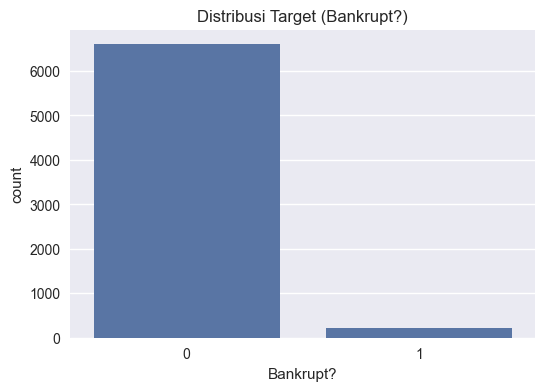

In [15]:
plt.figure(figsize=(6,4))
sns.countplot(x=df['Bankrupt?'])
plt.title("Distribusi Target (Bankrupt?)")
plt.show()

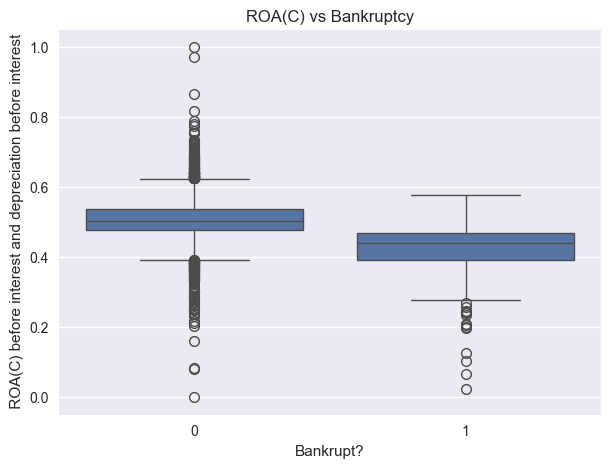

In [18]:
plt.figure(figsize=(7,5))
sns.boxplot(
    data=df,
    x='Bankrupt?',
    y=' ROA(C) before interest and depreciation before interest'
)
plt.title("ROA(C) vs Bankruptcy")
plt.show()

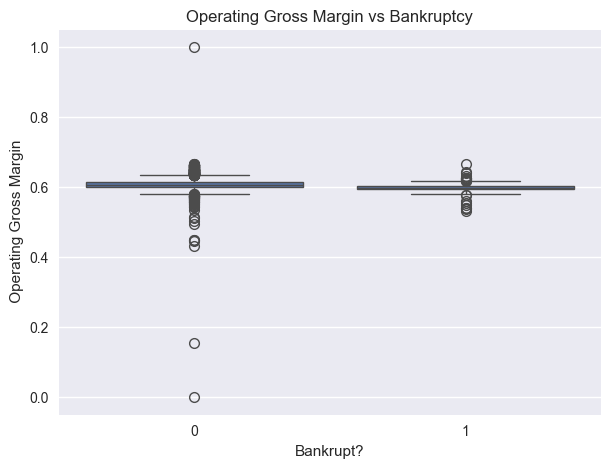

In [20]:
plt.figure(figsize=(7,5))
sns.boxplot(
    data=df,
    x='Bankrupt?',
    y=' Operating Gross Margin'
)
plt.title("Operating Gross Margin vs Bankruptcy")
plt.show()

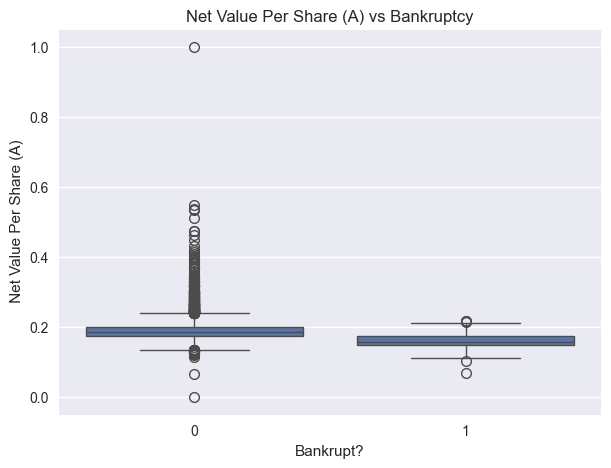

In [21]:
plt.figure(figsize=(7,5))
sns.boxplot(
    data=df,
    x='Bankrupt?',
    y=' Net Value Per Share (A)'
)
plt.title("Net Value Per Share (A) vs Bankruptcy")
plt.show()

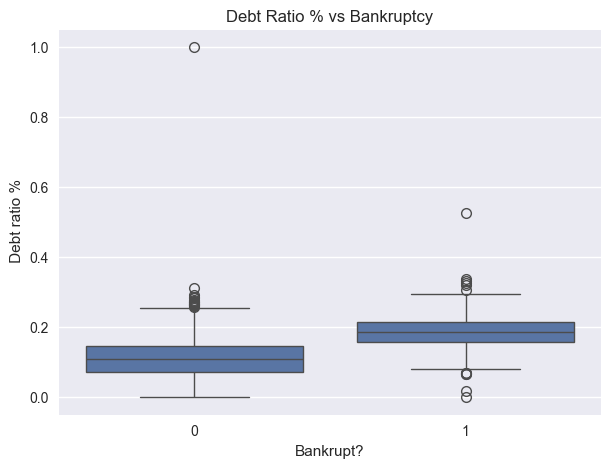

In [22]:
plt.figure(figsize=(7,5))
sns.boxplot(
    data=df,
    x='Bankrupt?',
    y=' Debt ratio %'
)
plt.title("Debt Ratio % vs Bankruptcy")
plt.show()

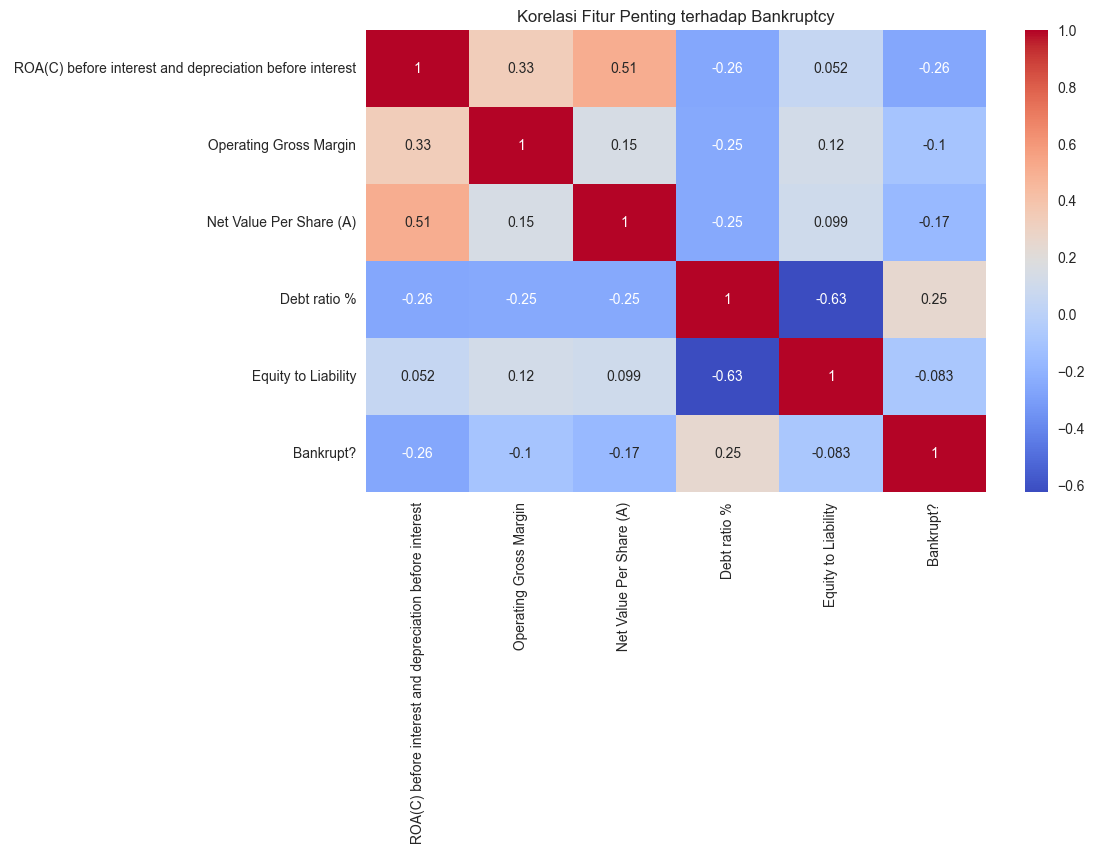

In [23]:
important_cols = [
    ' ROA(C) before interest and depreciation before interest',
    ' Operating Gross Margin',
    ' Net Value Per Share (A)',
    ' Debt ratio %',
    ' Equity to Liability'
]

plt.figure(figsize=(10,6))
sns.heatmap(df[important_cols + ['Bankrupt?']].corr(), annot=True, cmap='coolwarm')
plt.title("Korelasi Fitur Penting terhadap Bankruptcy")
plt.show()

In [24]:
#Cek Data

In [25]:
# Explorasi data dasar
print("Shape dataset:", df.shape)
print("\nInfo dataset:")
print(df.info())
print("\nStatistik deskriptif:")
print(df.describe())
print("\nDistribusi target variable:")
print(df['Bankrupt?'].value_counts())
print("\nProporsi target variable:")
print(df['Bankrupt?'].value_counts(normalize=True))

Shape dataset: (6819, 96)

Info dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6819 entries, 0 to 6818
Data columns (total 96 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   Bankrupt?                                                 6819 non-null   int64  
 1    ROA(C) before interest and depreciation before interest  6819 non-null   float64
 2    ROA(A) before interest and % after tax                   6819 non-null   float64
 3    ROA(B) before interest and depreciation after tax        6819 non-null   float64
 4    Operating Gross Margin                                   6819 non-null   float64
 5    Realized Sales Gross Margin                              6819 non-null   float64
 6    Operating Profit Rate                                    6819 non-null   float64
 7    Pre-tax net Interest Rate                                6819 n

In [26]:
# Cek total missing values per kolom
print("Missing Values per Kolom:")
print(df.isnull().sum())

# Cek total missing values di seluruh dataset
total_missing = df.isnull().sum().sum()
print(f"\nTotal Missing Values: {total_missing}")

Missing Values per Kolom:
Bankrupt?                                                   0
 ROA(C) before interest and depreciation before interest    0
 ROA(A) before interest and % after tax                     0
 ROA(B) before interest and depreciation after tax          0
 Operating Gross Margin                                     0
                                                           ..
 Liability to Equity                                        0
 Degree of Financial Leverage (DFL)                         0
 Interest Coverage Ratio (Interest expense to EBIT)         0
 Net Income Flag                                            0
 Equity to Liability                                        0
Length: 96, dtype: int64

Total Missing Values: 0


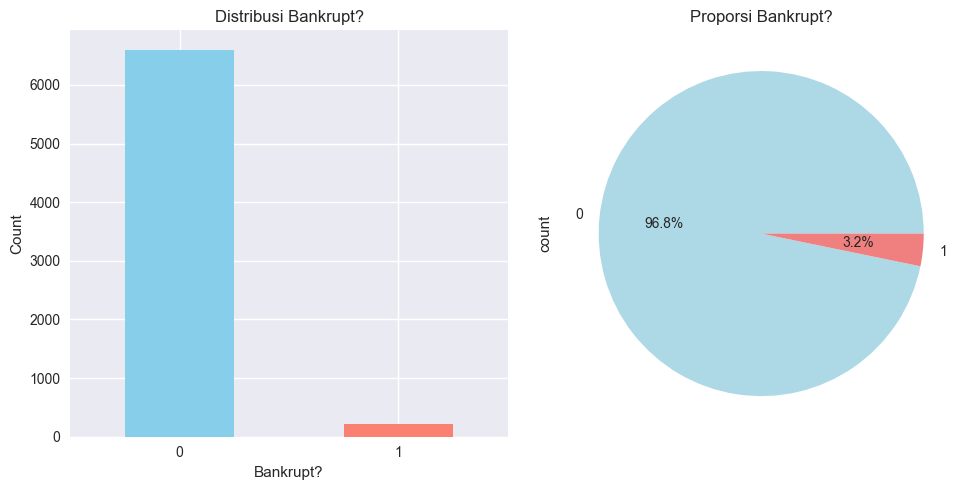

In [27]:
# Visualisasi distribusi target variable
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
df['Bankrupt?'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Distribusi Bankrupt?')
plt.xlabel('Bankrupt?')
plt.ylabel('Count')
plt.xticks(rotation=0)

plt.subplot(1, 2, 2)
df['Bankrupt?'].value_counts().plot(kind='pie', autopct='%1.1f%%', colors=['lightblue', 'lightcoral'])
plt.title('Proporsi Bankrupt?')

plt.tight_layout()
plt.show()

In [28]:
# Analisis korelasi dengan target variable
correlations = df.corr()['Bankrupt?'].sort_values(ascending=False)
print("10 fitur dengan korelasi positif tertinggi:")
print(correlations.head(10))

10 fitur dengan korelasi positif tertinggi:
Bankrupt?                               1.000000
 Debt ratio %                           0.250161
 Current Liability to Assets            0.194494
 Borrowing dependency                   0.176543
 Current Liability to Current Assets    0.171306
 Liability to Equity                    0.166812
 Current Liabilities/Equity             0.153828
 Current Liability to Equity            0.153828
 Liability-Assets Flag                  0.139212
 Total expense/Assets                   0.139049
Name: Bankrupt?, dtype: float64


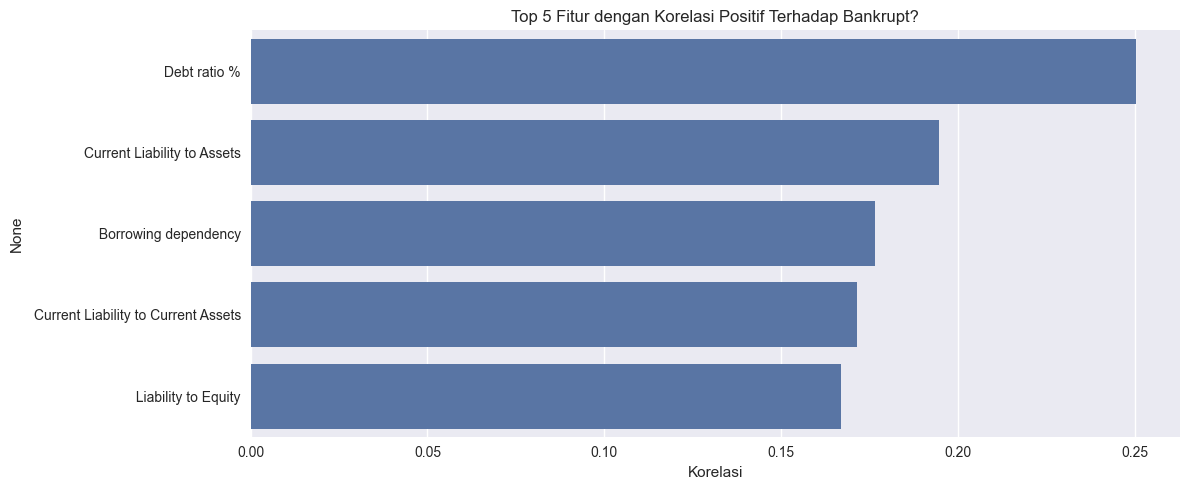

In [29]:
# Visualisasi korelasi top 5
plt.figure(figsize=(12, 5))
top_features = correlations.drop('Bankrupt?').head(5)
sns.barplot(x=top_features.values, y=top_features.index)
plt.title('Top 5 Fitur dengan Korelasi Positif Terhadap Bankrupt?')
plt.xlabel('Korelasi')
plt.tight_layout()
plt.show()

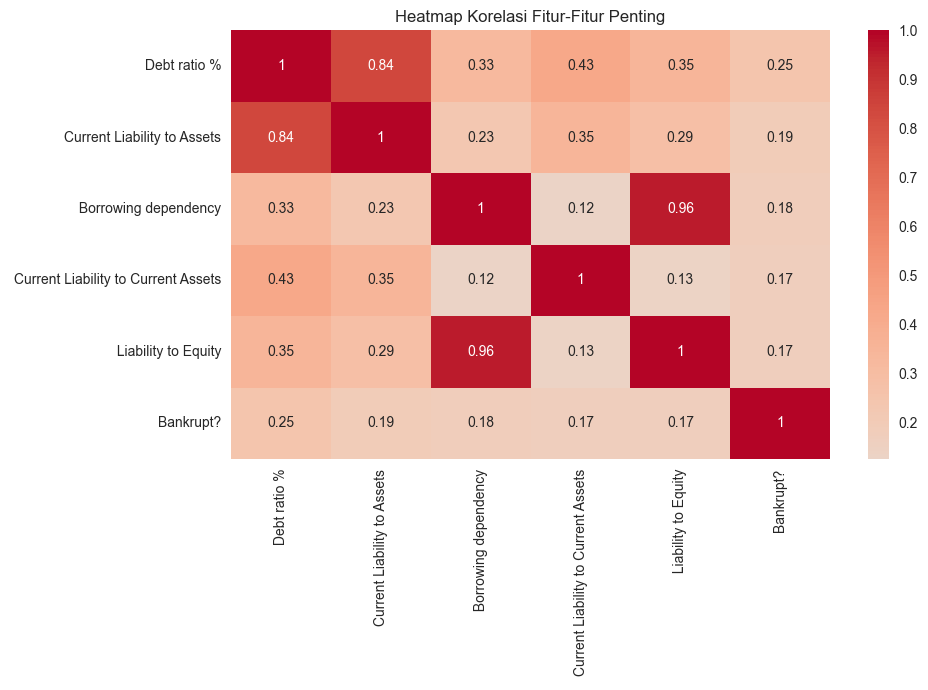

In [30]:
# Heatmap korelasi untuk fitur-fitur penting
selected_features = list(top_features.index[:8]) + ['Bankrupt?']
plt.figure(figsize=(10, 7))
sns.heatmap(df[selected_features].corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Heatmap Korelasi Fitur-Fitur Penting')
plt.tight_layout()
plt.show()

In [ ]:
#Data Preparation

In [31]:
# 3. Data Preparation
X = df.drop('Bankrupt?', axis=1)
y = df['Bankrupt?']

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\n=== DATA SPLITTING ===")
print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"Distribusi training - Tidak Bangkrut: {sum(y_train == 0)}, Bangkrut: {sum(y_train == 1)}")
print(f"Distribusi test - Tidak Bangkrut: {sum(y_test == 0)}, Bangkrut: {sum(y_test == 1)}")

# Standardisasi fitur
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\n=== SETELAH STANDARDISASI ===")
print(f"X_train_scaled shape: {X_train_scaled.shape}")
print(f"X_test_scaled shape: {X_test_scaled.shape}")


=== DATA SPLITTING ===
Training set: (5455, 95)
Test set: (1364, 95)
Distribusi training - Tidak Bangkrut: 5279, Bangkrut: 176
Distribusi test - Tidak Bangkrut: 1320, Bangkrut: 44

=== SETELAH STANDARDISASI ===
X_train_scaled shape: (5455, 95)
X_test_scaled shape: (1364, 95)


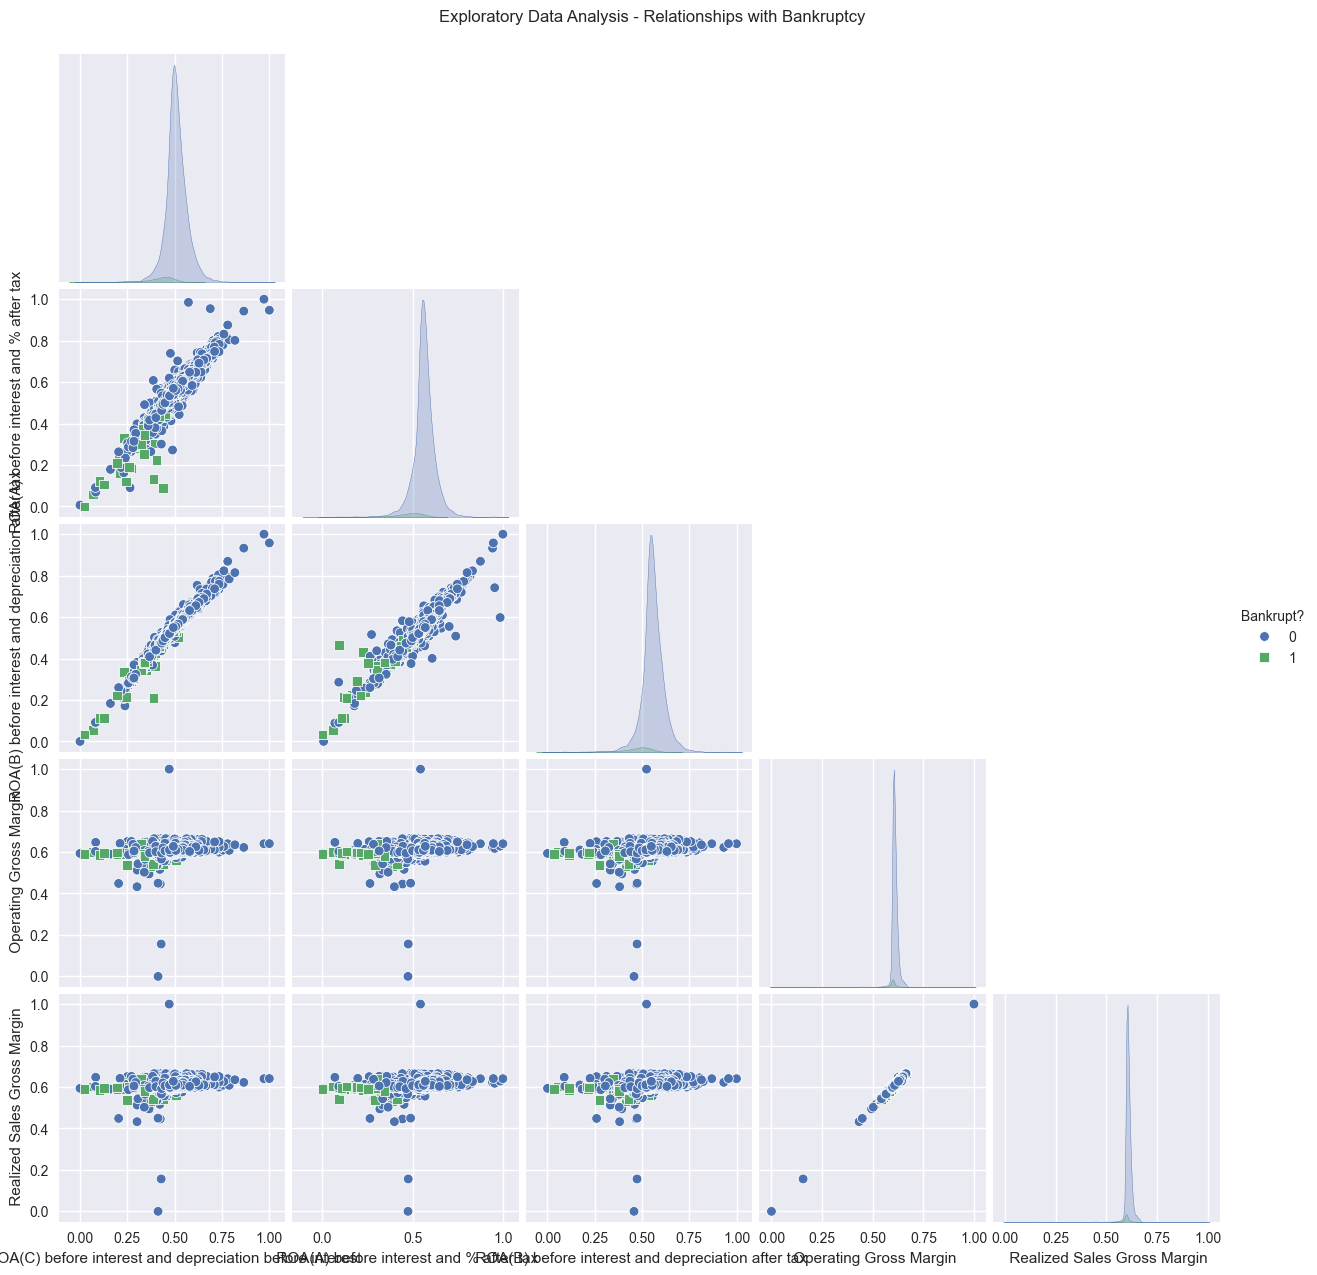

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt
subset_data_clean = df.iloc[:, :6]  # 6 kolom pertama
subset_data_clean["Bankrupt?"] = df["Bankrupt?"]

numeric_cols = subset_data_clean.select_dtypes(include=['float64','int64'])

plot_df = numeric_cols.copy()
plot_df["Bankrupt?"] = subset_data_clean["Bankrupt?"]

sns.pairplot(plot_df, hue="Bankrupt?", diag_kind='kde', markers=["o", "s"], corner=True)
plt.suptitle("Exploratory Data Analysis - Relationships with Bankruptcy", y=1.02)
plt.show()

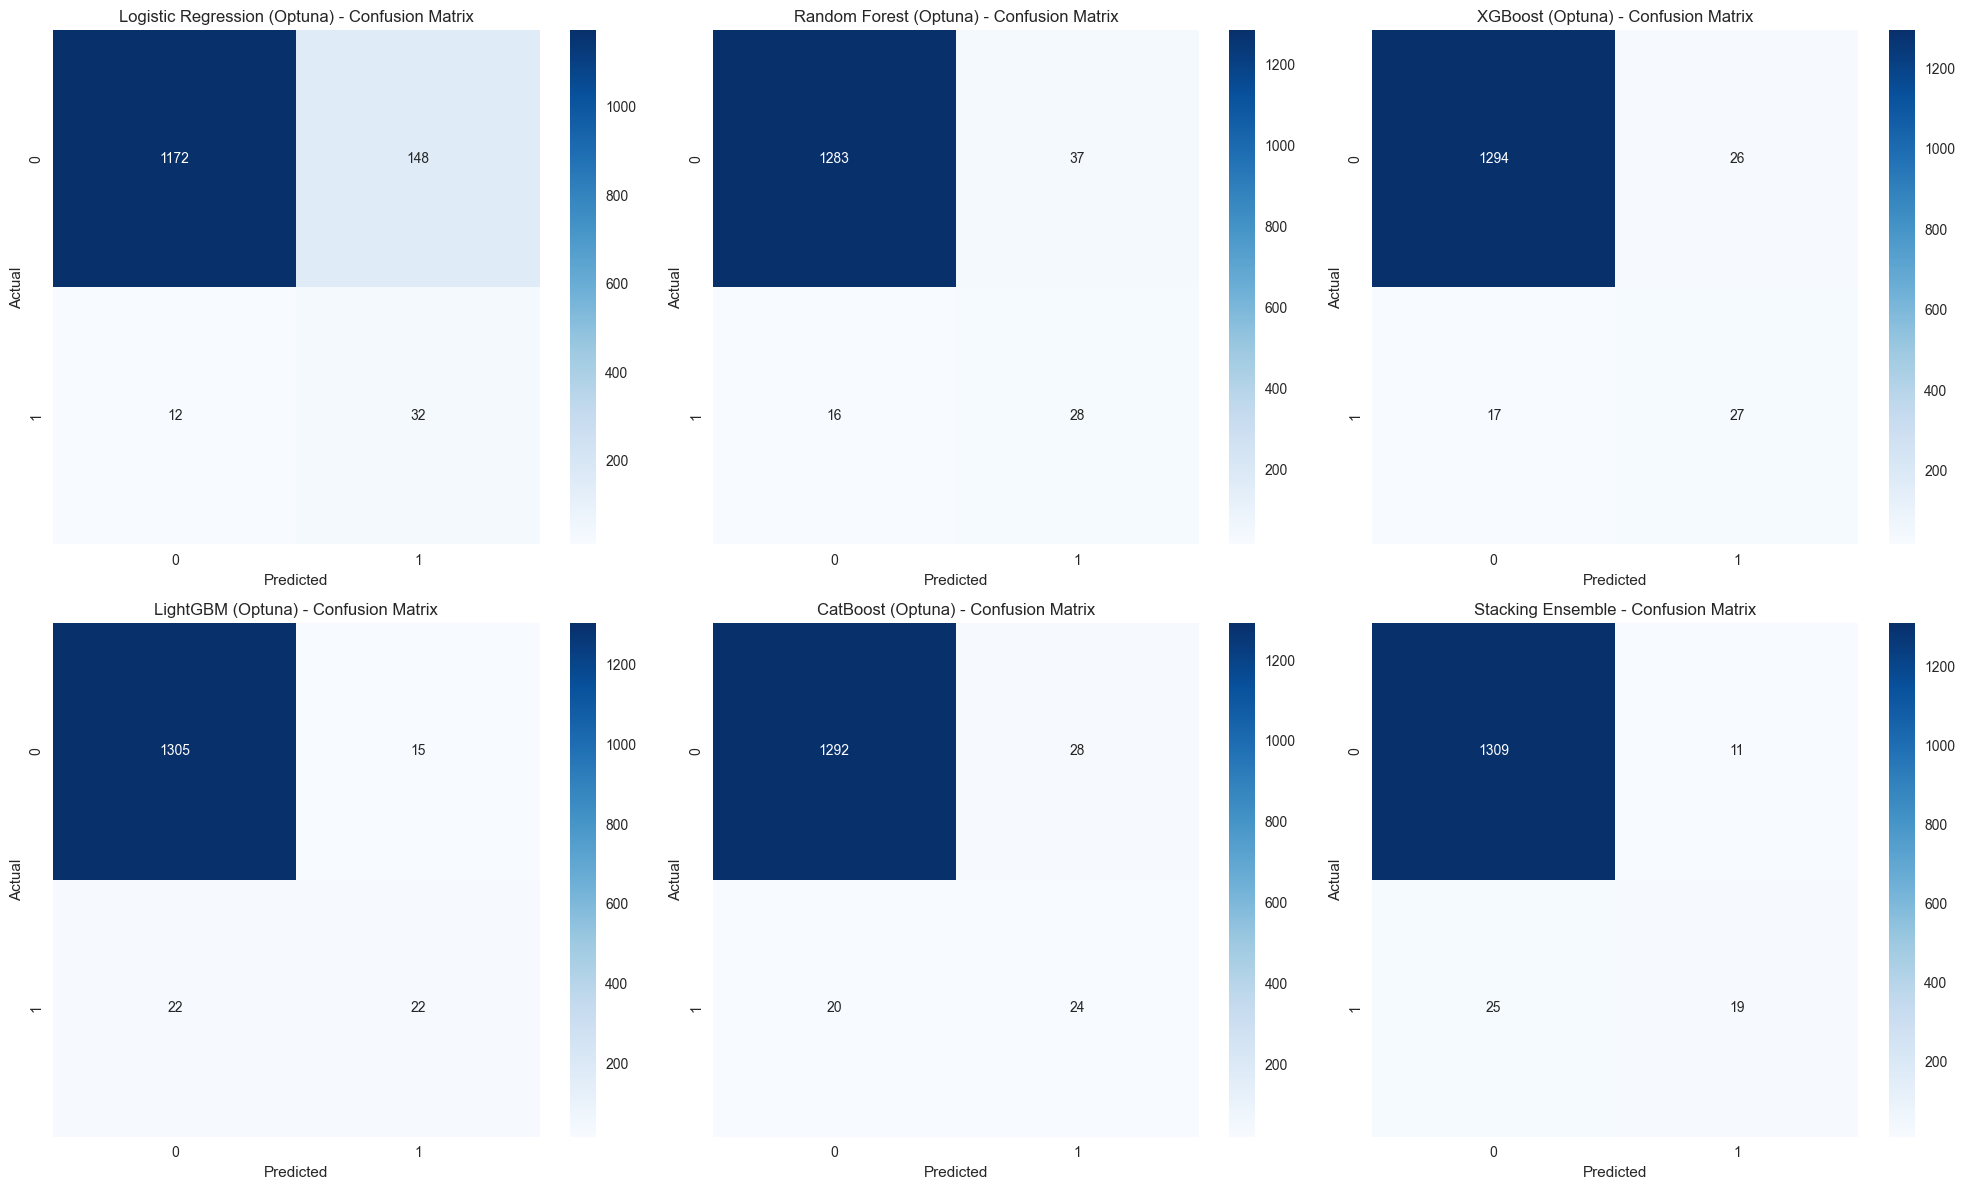


===== Logistic Regression (Optuna) =====
              precision    recall  f1-score   support

           0       0.99      0.89      0.94      1320
           1       0.18      0.73      0.29        44

    accuracy                           0.88      1364
   macro avg       0.58      0.81      0.61      1364
weighted avg       0.96      0.88      0.92      1364


===== Random Forest (Optuna) =====
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1320
           1       0.43      0.64      0.51        44

    accuracy                           0.96      1364
   macro avg       0.71      0.80      0.75      1364
weighted avg       0.97      0.96      0.96      1364


===== XGBoost (Optuna) =====
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      1320
           1       0.51      0.61      0.56        44

    accuracy                           0.97      1364
   macro avg       0

In [41]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

models = {
    "Logistic Regression (Optuna)": lr_opt,
    "Random Forest (Optuna)": rf_opt,
    "XGBoost (Optuna)": xgb_opt,
    "LightGBM (Optuna)": lgb_opt,
    "CatBoost (Optuna)": cat_opt,
    "Stacking Ensemble": stack
}

y_preds = {}
cms = {}

for name, model in models.items():
    y_pred = model.predict(X_test_scaled)
    y_preds[name] = y_pred
    cms[name] = confusion_matrix(y_test, y_pred)

# Plot Confusion Matrix untuk semua model
plt.figure(figsize=(20, 12))

for i, (name, cm) in enumerate(cms.items(), 1):
    plt.subplot(2, 3, i)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")

plt.tight_layout()
plt.show()

# Print Classification Report Semua Model
for name, y_pred in y_preds.items():
    print(f"\n===== {name} =====")
    print(classification_report(y_test, y_pred))

Dictionary model_objects lengkap — siap dipakai!

=== BEST MODELS LOADED ===
dict_keys(['StackingEnsemble (Stacking)', 'LightGBM (Optuna)', 'XGBoost (Optuna)', 'LightGBM (Baseline)', 'LightGBM (ClassWeight)', 'XGBoost (Baseline)', 'XGBoost (ClassWeight)', 'CatBoost (Baseline)', 'CatBoost (ClassWeight)', 'CatBoost (Optuna)', 'RandomForest (Optuna)', 'RandomForest (Baseline)', 'RandomForest (ClassWeight)', 'LogReg (Baseline)', 'LogReg (ClassWeight)', 'LogReg (Optuna)'])


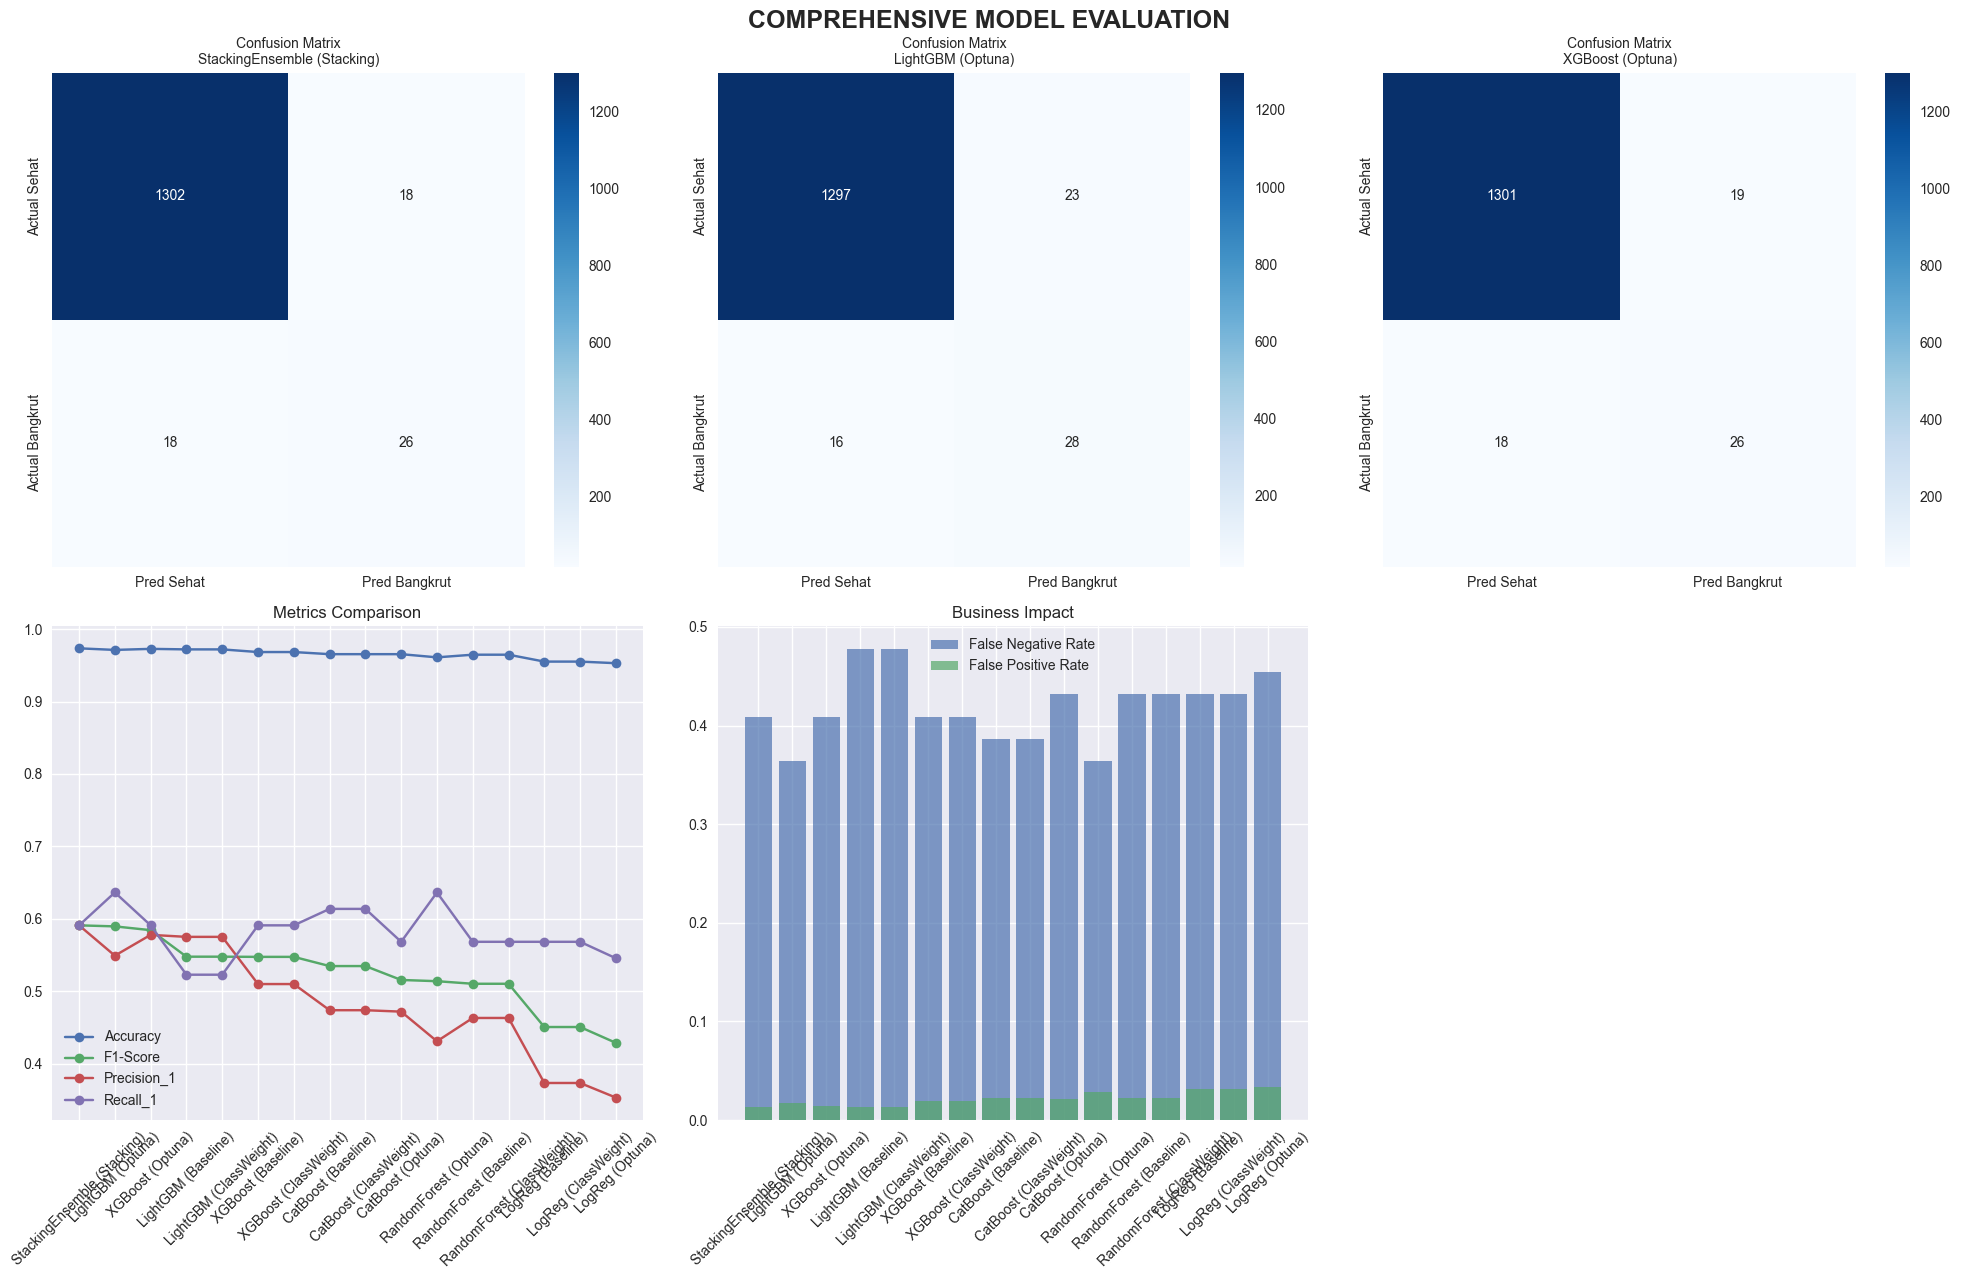

In [45]:
# ============================================
# CREATE MODEL OBJECT MAPPING
# ============================================
model_objects = {
    # Model-model dasar
    "Logistic Regression": lr_opt if "lr_opt" in globals() else lr_model,
    "Random Forest": rf_opt if "rf_opt" in globals() else rf_model,
    "XGBoost": xgb_opt if "xgb_opt" in globals() else xgb_model,
    "LightGBM": lgb_opt if "lgb_opt" in globals() else lgbm_model,
    "CatBoost": cat_opt if "cat_opt" in globals() else best_cat,

    # Variasi nama LR
    "LogReg": lr_opt,
    "LR": lr_opt,
    "LogisticRegression": lr_opt,

    # Variasi nama RF
    "RF": rf_opt,
    "RandomForest": rf_opt,
    "Random Forest Classifier": rf_opt,

    # Variasi nama XGB
    "XGB": xgb_opt,
    "XGBoostClassifier": xgb_opt,

    # Variasi nama LGB
    "LGB": lgb_opt,
    "LightGBMClassifier": lgb_opt,
    "LGBM": lgb_opt,

    # Variasi nama CATBOOST
    "CatBoostClassifier": cat_opt,
    "CAT": cat_opt,

    # Semua kemungkinan nama stacking
    "Stacking": stack,
    "Stack": stack,
    "StackingClassifier": stack,
    "Stacking Ensemble": stack,
    "StackingEnsemble": stack,
    "EnsembleStacking": stack,
    "StackEnsemble": stack,
    "MetaStack": stack,
    "Meta-Stack": stack,
}

print("Dictionary model_objects lengkap — siap dipakai!")

# ============================================
# SELECT TOP MODELS FROM final_df (e.g., Top 5)
# ============================================
top_models = final_df.head(5)

# ======================================
# BUILD BEST MODELS FROM final_df
# ======================================

best_models = {}

for idx, row in final_df.iterrows():
    model_name = row["Model"]
    method = row["Method"]
    key_name = f"{model_name} ({method})"

    # cek apakah model ada di dictionary
    if model_name not in model_objects:
        print(f"[WARNING] Model '{model_name}' tidak ditemukan di model_objects, SKIP")
        continue
    
    best_models[key_name] = {
        "model": model_objects[model_name],
        "confusion_matrix": np.array([
            [row["TN"], row["FP"]],
            [row["FN"], row["TP"]]
        ]),
        "Accuracy": (row["TP"] + row["TN"]) / (row["TP"] + row["TN"] + row["FP"] + row["FN"] + 1e-9),
        "F1-Score": row["F1_1"],
        "Precision_1": row["P1"],
        "Recall_1": row["R1"],
        "False_Negative_Rate": row["FN"] / (row["FN"] + row["TP"] + 1e-9),
        "False_Positive_Rate": row["FP"] / (row["FP"] + row["TN"] + 1e-9)
    }

print("\n=== BEST MODELS LOADED ===")
print(best_models.keys())

# ======================================
# VISUALISASI MODEL
# ======================================
if len(best_models) == 0:
    raise ValueError("best_models kosong → model tidak bisa divisualisasikan!")

fig, axes = plt.subplots(2, 3, figsize=(20, 13))
fig.suptitle('COMPREHENSIVE MODEL EVALUATION', fontsize=18, fontweight='bold')

# Ambil list model
models_list = list(best_models.keys())

# 1. Confusion matrix untuk 3 model pertama
for i, key in enumerate(models_list[:3]):
    cm = best_models[key]["confusion_matrix"]
    ax = axes[0, i]

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=['Pred Sehat', 'Pred Bangkrut'],
                yticklabels=['Actual Sehat', 'Actual Bangkrut'])
    ax.set_title(f'Confusion Matrix\n{key}', fontsize=10)

# 2. Bar plot metrics
metric_names = ["Accuracy", "F1-Score", "Precision_1", "Recall_1"]
values = {m: [best_models[k][m] for k in models_list] for m in metric_names}

ax = axes[1, 0]
for m in metric_names:
    ax.plot(models_list, values[m], marker='o', label=m)
ax.legend()
ax.set_title("Metrics Comparison")
ax.tick_params(axis='x', rotation=45)

# 3. False rates
fn = [best_models[k]["False_Negative_Rate"] for k in models_list]
fp = [best_models[k]["False_Positive_Rate"] for k in models_list]

ax = axes[1, 1]
ax.bar(models_list, fn, label='False Negative Rate', alpha=0.7)
ax.bar(models_list, fp, label='False Positive Rate', alpha=0.7)
ax.set_title("Business Impact")
ax.legend()
ax.tick_params(axis='x', rotation=45)

# Kosongkan 1 plot agar layout rapi
axes[1, 2].axis('off')

plt.tight_layout()
plt.show()



📊 ROC ANALYSIS:


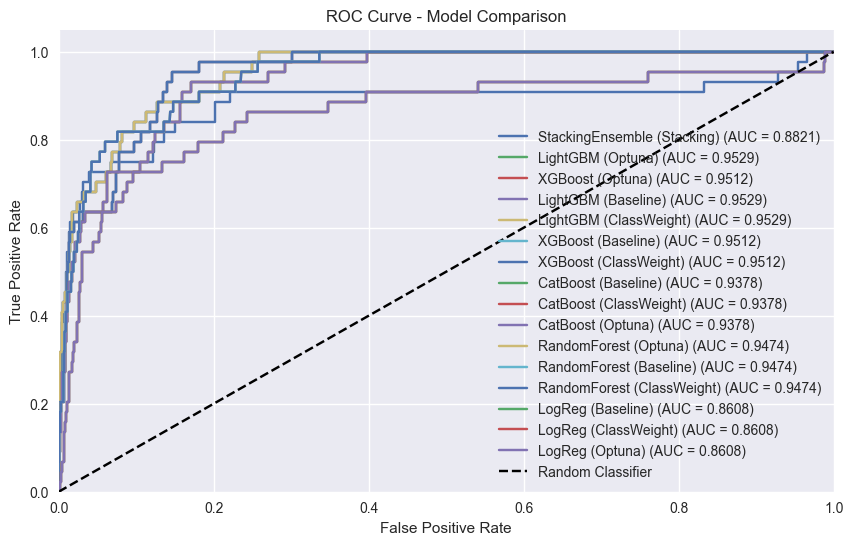

In [46]:
# ROC Curve untuk model terbaik
print(f"\n📊 ROC ANALYSIS:")
try:
    from sklearn.metrics import roc_curve, auc

    plt.figure(figsize=(10, 6))
    for name, result in best_models.items():
        model = result['model']
        if hasattr(model, 'predict_proba'):
            y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
            fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
            roc_auc = auc(fpr, tpr)

            plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.4f})')

    plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - Model Comparison')
    plt.legend()
    plt.grid(True)
    plt.show()

except Exception as e:
    print(f"Error dalam ROC analysis: {e}")

In [60]:
print(pd.Series(best_models[key_name]["model"].predict(X_test)).value_counts())

0    1364
Name: count, dtype: int64


In [61]:
print(final_df.head(5))

   Rank       Method             Model        P1        R1      F1_1  \
0     1     Stacking  StackingEnsemble  0.590909  0.590909  0.590909   
1     2       Optuna          LightGBM  0.549020  0.636364  0.589474   
2     3       Optuna           XGBoost  0.577778  0.590909  0.584270   
3     4     Baseline          LightGBM  0.575000  0.522727  0.547619   
4     5  ClassWeight          LightGBM  0.575000  0.522727  0.547619   

         P0        R0      F1_0       AUC  threshold  TP  FP  FN    TN  
0  0.986364  0.986364  0.986364  0.882128       0.10  26  18  18  1302  
1  0.987814  0.982576  0.985188  0.952858       0.18  28  23  16  1297  
2  0.986353  0.985606  0.985980  0.951171       0.60  26  19  18  1301  
3  0.984139  0.987121  0.985628  0.948691       0.49  23  17  21  1303  
4  0.984139  0.987121  0.985628  0.948691       0.49  23  17  21  1303  


In [62]:
best_tree_model = model_objects["XGBoost"]  # atau LightGBM

importance = best_tree_model.feature_importances_

importance_df = pd.DataFrame({
    "Feature": X_train.columns,
    "Importance": importance
}).sort_values("Importance", ascending=False)

importance_df.head(10)

,Feature,Importance
39,Borrowing dependency,0.139842
9,Continuous interest rate (after tax),0.107043
85,Net Income to Total Assets,0.098487
37,Net worth/Assets,0.079625
35,Total debt/Total net worth,0.031950
8,Non-industry income and expenditure/revenue,0.025259
94,Equity to Liability,0.023817
18,Persistent EPS in the Last Four Seasons,0.023073
1,ROA(A) before interest and % after tax,0.019438
62,Inventory/Current Liability,0.016742


In [63]:
stack.estimators_  

[LogisticRegression(C=8.959942069691541, max_iter=1000, random_state=42),
 RandomForestClassifier(max_depth=30, min_samples_split=3, n_estimators=404,
                        random_state=42),
 XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=0.6103513999042456, device=None,
               early_stopping_rounds=None, enable_categorical=False,
               eval_metric=None, feature_types=None, gamma=None,
               grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=0.0896217586570151,
               max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=5, max_leaves=None,
               min_child_weight=1, missing=nan, monotone_constraints=None,
               multi_strategy=None, n_estimators=478, n_jobs=None,
               num_parallel_tree=None, random_state=42, ...),
 LG